# Exploratory Data Analysis - Financial Loans

The aim of this project is to gain insights into the portfolio of a loan company. In this notebook, we will be covering how the data is cleaned and prepared for analysis.

In [1]:
from loan_data_analysis import *

## Getting Familiar With the Data
The raw data was obtained by connecting to a RDS Database and saving the data locally.

In [2]:
loan_data = pd.read_csv('loans_data_raw.csv')

# Create a copy of the DataFrame for backup
loan_data_copy = loan_data.copy()

df_info = DataFrameInfo(loan_data)

#### How much data are we handling?

In [3]:
print("Shape of the DataFrame:")
print(df_info.print_shape())

Shape of the DataFrame:
(54231, 43)


We can see we are working with a medium sized dataset of over 50,000 records, and 43 variables being tracked.

#### Handling Data Types
First we will check the dataframe for data types and then decide which columns will have to change data types.

In [4]:
print("Column Descriptions:")
print(df_info.describe_columns())

Column Descriptions:
id                               int64
member_id                        int64
loan_amount                      int64
funded_amount                  float64
funded_amount_inv              float64
term                            object
int_rate                       float64
instalment                     float64
grade                           object
sub_grade                       object
employment_length               object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_date                      object
loan_status                     object
payment_plan                    object
purpose                         object
dti                            float64
delinq_2yrs                      int64
earliest_credit_line            object
inq_last_6mths                   int64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_accounts                    int64
tota

From this we can see the following columns are the object data type and will be converted as follows:

convert to the __category__ data type:

- term
- home_ownership
- verification_status

convert to the __ordered category__ data type:
- employment_length
- grade
- sub_grade

convert to the __datetime__ data type:

- issue_date
- earliest_credit_line
- last_payment_date
- next_payment_date
- last_credit_pull_date

In [5]:
df_transform = DataTransform(loan_data)

category_column_names = ["term","grade","sub_grade","employment_length","home_ownership","verification_status"]
df = df_transform.convert_to_category(category_column_names)

# Convert columns to ordered category type
col_order = {
    "employment_length": ["< 1 year", "1 year", "2 years", "3 years", "4 years","5 years", "6 years","7 years", "8 years","9 years", "10+ years"],
    "grade": ["A","B","C","D","E","F"],
    "sub_grade": ["A1","A2","A3","A4","A5","B1","B2","B3","B4","B5","C1","C2","C3","C4","C5","D1","D2","D3","D4","D5","E1","E2","E3","E4","E5","F1","F2","F3","F4","F5"]
}
df = df_transform.convert_to_ordered_category(col_order)


date_column_names = ["issue_date","earliest_credit_line","last_payment_date","last_credit_pull_date"]
df = df_transform.convert_to_date(date_column_names)

# Check columns have been converted correctly
print(df.dtypes)

id                                      int64
member_id                               int64
loan_amount                             int64
funded_amount                         float64
funded_amount_inv                     float64
term                                 category
int_rate                              float64
instalment                            float64
grade                                category
sub_grade                            category
employment_length                    category
home_ownership                       category
annual_inc                            float64
verification_status                  category
issue_date                     datetime64[ns]
loan_status                            object
payment_plan                           object
purpose                                object
dti                                   float64
delinq_2yrs                             int64
earliest_credit_line           datetime64[ns]
inq_last_6mths                    

#### Exploring the Categorical Data

In [6]:
cat_stats = df_info.count_distinct_values_and_mode()

# Convert stats dictionary to a DataFrame for better readability
cat_stats_df = pd.DataFrame(cat_stats).T  # Transpose the table so columns are rows
cat_stats_df.index.name = 'Variable' 
print(cat_stats_df)

                    Distinct Count                Mode
Variable                                              
term                             2           36 months
grade                            6                   B
sub_grade                       30                  B3
employment_length               11           10+ years
home_ownership                   5            MORTGAGE
verification_status              3            Verified
loan_status                      9          Fully Paid
payment_plan                     2                   n
purpose                         14  debt_consolidation
next_payment_date               96            Feb-2022
application_type                 1          INDIVIDUAL


From this we know all the loans are for an individual. The most common reason for a loan is debt consolidation. The loan terms can either be 60 or 36 months, the most common being 36 months. The most common employment length is 10+ years and are paying a mortgage. The most common grade is B and most common loan status is fully paid. These initial indicators show no reason to be concerned for the company's portfolio.

#### Exploring the Numeric Data

In [7]:
stats_dict = df_info.extract_statistics()
formatted_stats_dict = {key: stats_dict[key].apply(lambda x: f"{x:,.2f}") for key in stats_dict}

 # Convert stats dictionary to a DataFrame for better readability
num_stats_df = pd.DataFrame(formatted_stats_dict) 
num_stats_df.index.name = 'Variable' 
print(num_stats_df)

                                     Mean        Median        Std Dev
Variable                                                              
id                           7,621,797.48  7,084,590.00   9,571,361.65
member_id                    8,655,349.93  8,709,873.00  10,312,806.88
loan_amount                     13,333.08     12,000.00       8,082.20
funded_amount                   13,229.51     12,000.00       8,019.02
funded_amount_inv               12,952.62     11,300.00       8,099.47
int_rate                            13.51         13.16           4.39
instalment                         400.01        347.15         238.92
annual_inc                      72,220.85     61,000.00      51,589.34
dti                                 15.87         15.60           7.62
delinq_2yrs                          0.24          0.00           0.71
inq_last_6mths                       0.89          1.00           1.26
mths_since_last_delinq              34.02         31.00          21.92
mths_s

Key Averages
- loan_amount £13,333.08
- total_payment £12,079.21 which is below the loan_amount, suggesting they are working at a loss.
- int_rate 13.51% this is considered a high interest rate for a personal loan.

Some strange results can be seen by these preliminary calculations, the standard deviation of the loan amount is 8,082.20. With some cleaning of the data,  we can increase confidence in the insights gathered.

## Handling Null Values
Handling null values is important as they can effect the accuracy of future analysis and cause errors in our code.

#### Null Value Summary

First let us calculate the count and percentage of null values in each column to give us an idea of what we are working with.


In [8]:
null_summary = df_info.count_null_values()
null_summary_filtered = null_summary[(null_summary.percentage > 0)].sort_values('percentage',ascending=False)
print("Null Value Summary:")
print(null_summary_filtered)
print(f"\n Number of columns with null values {(null_summary['count'] != 0).sum()}")

Null Value Summary:
                             count  percentage
mths_since_last_record       48050   88.602460
mths_since_last_major_derog  46732   86.172116
next_payment_date            32608   60.127971
mths_since_last_delinq       31002   57.166565
int_rate                      5169    9.531449
term                          4772    8.799395
funded_amount                 3007    5.544799
employment_length             2118    3.905515
grade                          521    0.960705
sub_grade                      521    0.960705
last_payment_date               73    0.134609
collections_12_mths_ex_med      51    0.094042
last_credit_pull_date            7    0.012908

 Number of columns with null values 13


There are 13 variables with null values ranging from 86% to less than 1%, each one will have to be handled on a case by case basis.

#### Dropping Columns

Variables with a null value percentage greater than 50% will be dropped as dropping the missing samples would reduce the dataset too much. This includes:
- mths_since_last_delinq
- mths_since_last_record  
- next_payment_date 
- mths_since_last_major_derog 

In [9]:
df_transform = DataFrameTransform(df)

thresh_max = 50  # threshold percentage 
df_transform.drop_columns(null_summary,thresh_max)

Columns to drop: ['mths_since_last_delinq', 'mths_since_last_record', 'next_payment_date', 'mths_since_last_major_derog']
New shape: (54231, 39)


#### Dropping Rows

The following variables have null values percentages of below 1%:
- last_payment_date (0.13%)
- last_credit_pull_date (0.01%)
- collections_12_mths_ex_med (0.09%)

Removing the null values of these variables will not reduce the size of the data set too much so it is easier to drop the rows with null values, additionally the variables with datetime data type (last_payment_date and last_credit_pull_date) would be difficult to impute.

The employment_length variable has a null percentage of 3.9% which is worth considering imputing. First lets look at the spread of the data by plotting a histogram to check the distribution.

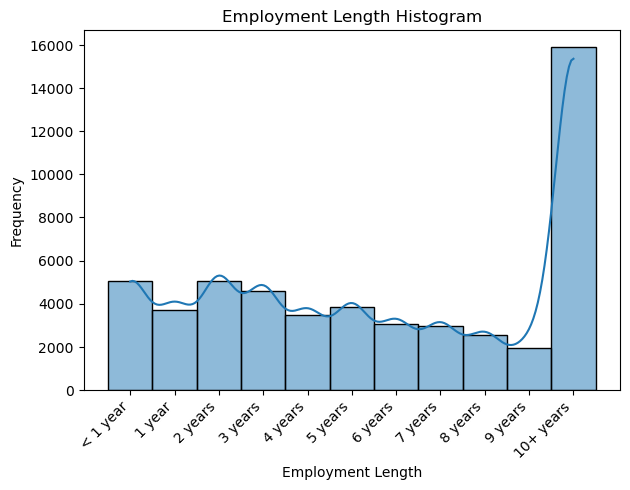

In [10]:
df_sorted = df_transform.df.sort_values(by='employment_length')
x_val = df_sorted['employment_length']

employment_length_inst = Plotter(df_sorted)
employment_length_hist = employment_length_inst.histogram(x_val,"Employment Length", "Employment Length Histogram")

The histogram shows that the mode is 10+ years of employment, which makes sense as that captures the largest range of years. Since it does not have a normal distribution imputing it with the mode would introduce bias and the employment_length cannot be infered from other data in this dataset. The best option is to drop the rows with null values. 

Setting a threshold of 4% ensures the employment_length, last_payment_date, last_credit_pull_date, collections_12_mths_ex_med are dropped.

In [11]:
thresh_min = 4 

df_transform.drop_rows(null_summary,thresh_min)

Drop rows with null values from: ['grade', 'sub_grade', 'employment_length', 'last_payment_date', 'last_credit_pull_date', 'collections_12_mths_ex_med']
New shape: (51481, 39)


#### Inferring missing data

Funded Amount

The funded_amount is very similar to the loan amount so we can imptute the data using the corresponding loan data.

In [12]:
df_transform.df['funded_amount'] = df_transform.df['funded_amount'].fillna(value=df_transform.df['loan_amount'])
null_summary.loc['funded_amount',:]

count         3007.000000
percentage       5.544799
Name: funded_amount, dtype: float64

Term

The term can only be a 36 months or 60 months, the missing term values can be calculated by multiplying the instalment by 36 or 60 and choosing the one closer to the loan amount.

In [13]:
# Calculate the predited loan amounts
loan_36 = df_transform.df['instalment'] * 36
loan_60 = df_transform.df['instalment'] * 60

# Calculate the difference between the real loan and predicted loan
dif_36 =  df_transform.df['loan_amount'] - loan_36
dif_60 =  df_transform.df['loan_amount'] - loan_60

# Create a DataFrame to display the series and the comparison result
df_comparison = pd.DataFrame({
    '36': dif_36,
    '60': dif_60
})

# Determine if the term is 36 or 60 months
df_comparison['term'] = df_comparison.apply(lambda row: '60' if row['36'] > 0 else '36', axis=1)

df_check = pd.DataFrame({
    "calc_term": df_comparison['term'],
    'real_term' : df_transform.df['term'],

})

# Check the calculated term are the same as the real term
print(df_check.head(9))

# Update term with calculated term
df_transform.df['term'] = df_comparison['term']

print('number of term null values',df_transform.df['term'].isnull().sum())

  calc_term  real_term
0        36  36 months
1        36  36 months
2        36  36 months
3        36  36 months
4        36  36 months
5        36  36 months
7        60        NaN
8        60  60 months
9        36  36 months
number of term null values 0


#### Mean Imputation

The interest rate can be imputed using the mean/median as the null percentage is less than 10%, as the bias and increase of variance will be negligble. To decide which imputation method to use we will check the skew of the distribution.

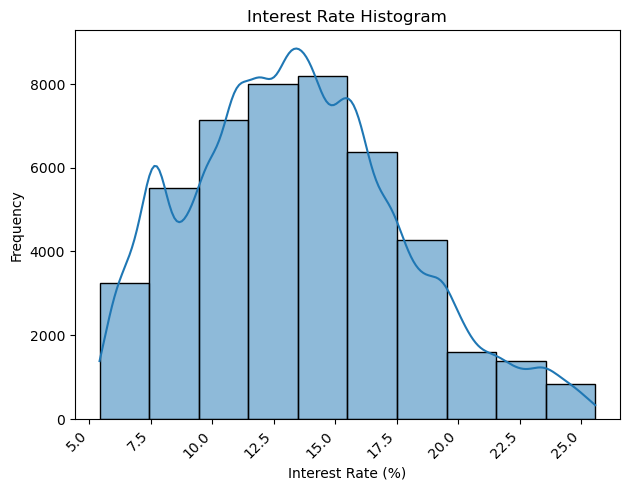

In [14]:
x_int_rate = df_transform.df['int_rate'] 
data_vis = Plotter(df_transform.df)
int_rate_hist = data_vis.histogram(x_int_rate,"Interest Rate (%)", "Interest Rate Histogram")

In [15]:
print(f'The median of int_rate is {df_transform.df["int_rate"].median()}')
print(f'The mean of int_rate is {df_transform.df["int_rate"].mean()}')

The median of int_rate is 13.06
The mean of int_rate is 13.423129066197154


The interest rate has a right skewed distribution, which typically increases the mean as seen in our calculations. A median imputation is  the better option in this scenario.

It could be interesting to see a correlation matrix to determine which variable is mostly strongly correlated and doing a regression based off that and comparing the result to the median regression, testing wheather our assumption that a null percentage value of less than 10% is an acceptable threshold.

In [16]:
df_transform.df['int_rate'] = df_transform.impute_median('int_rate')

#### Visualising the Change in Null Values

Using the missingno package we are able to visualise the null values in the dataset. Every white line is a missing record.

Snapshot of dataset *before* cleaning.

<Axes: >

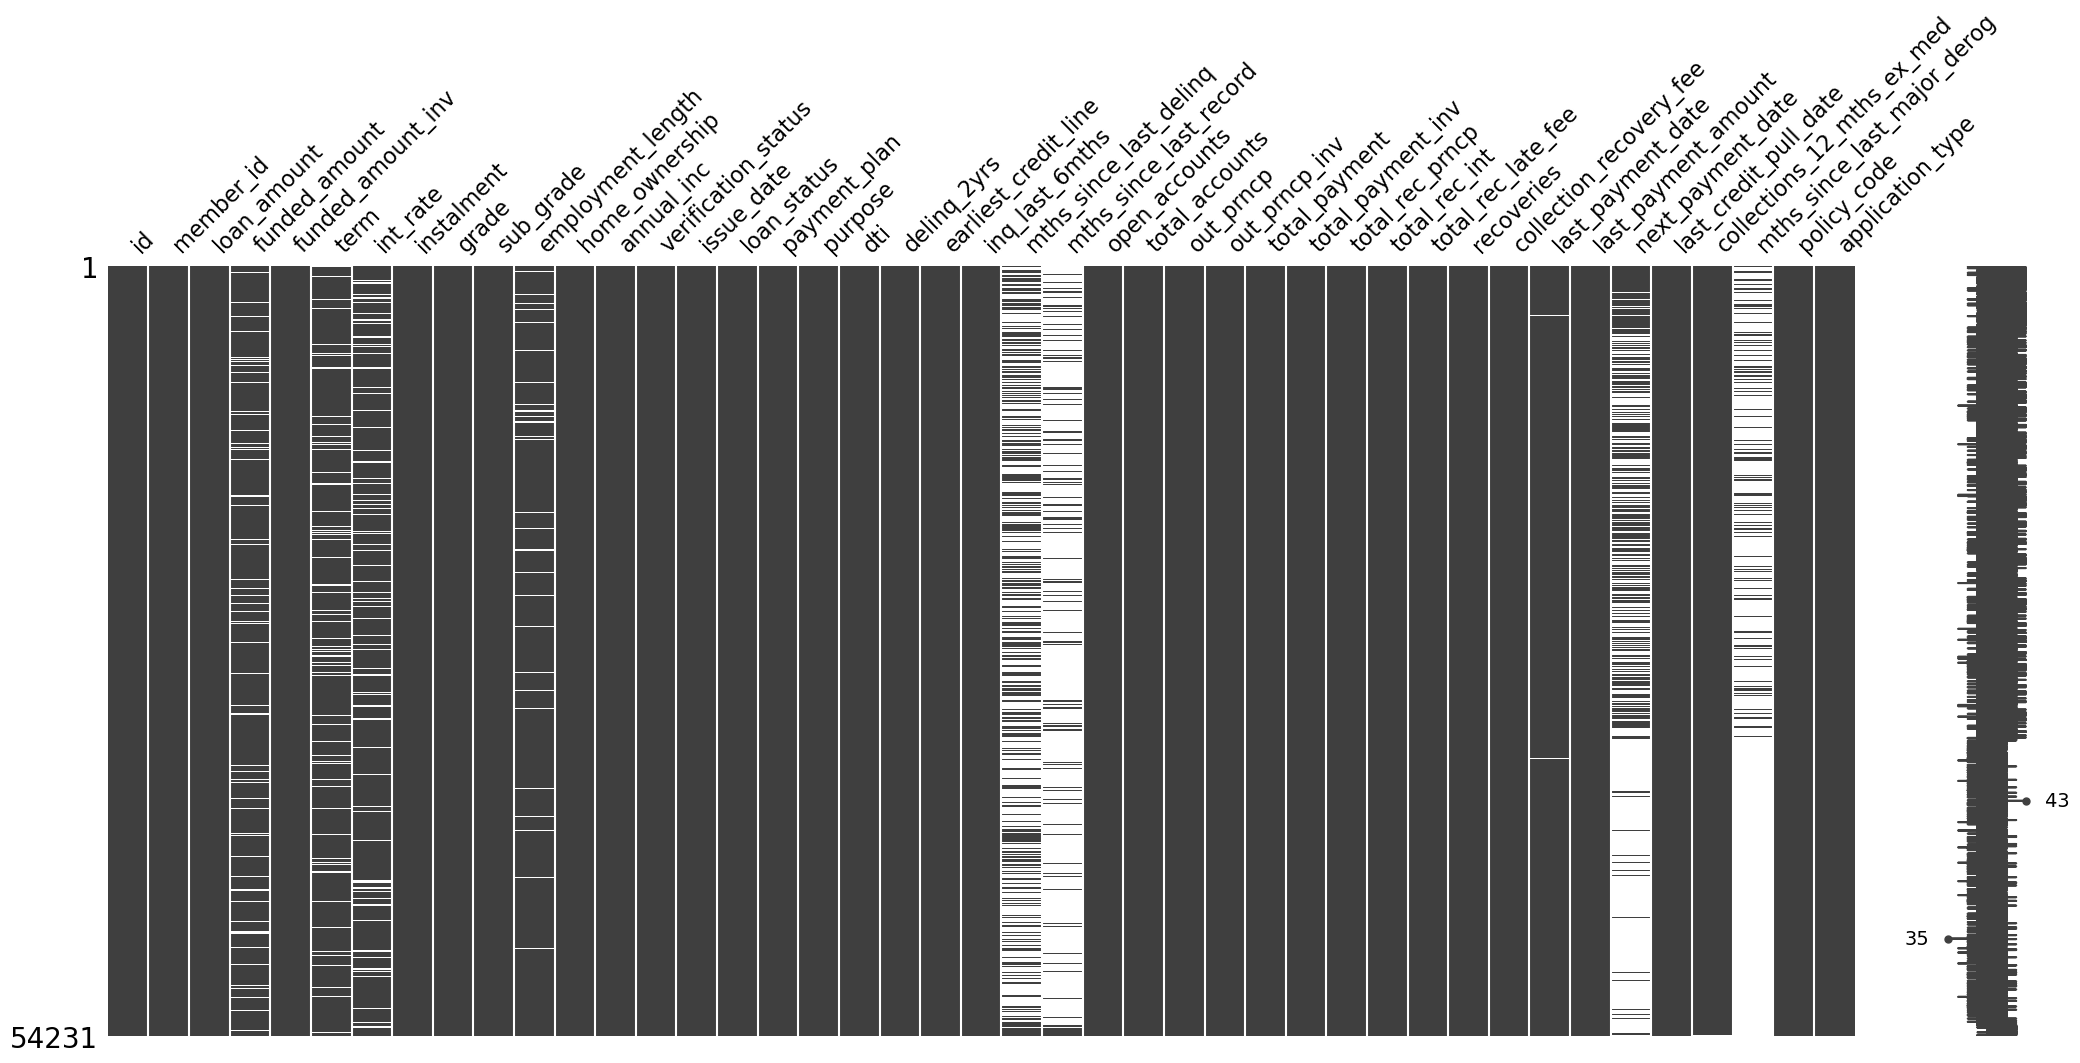

In [17]:
msno.matrix(loan_data_copy)

Snapshot of dataset *after* cleaning.

<Axes: >

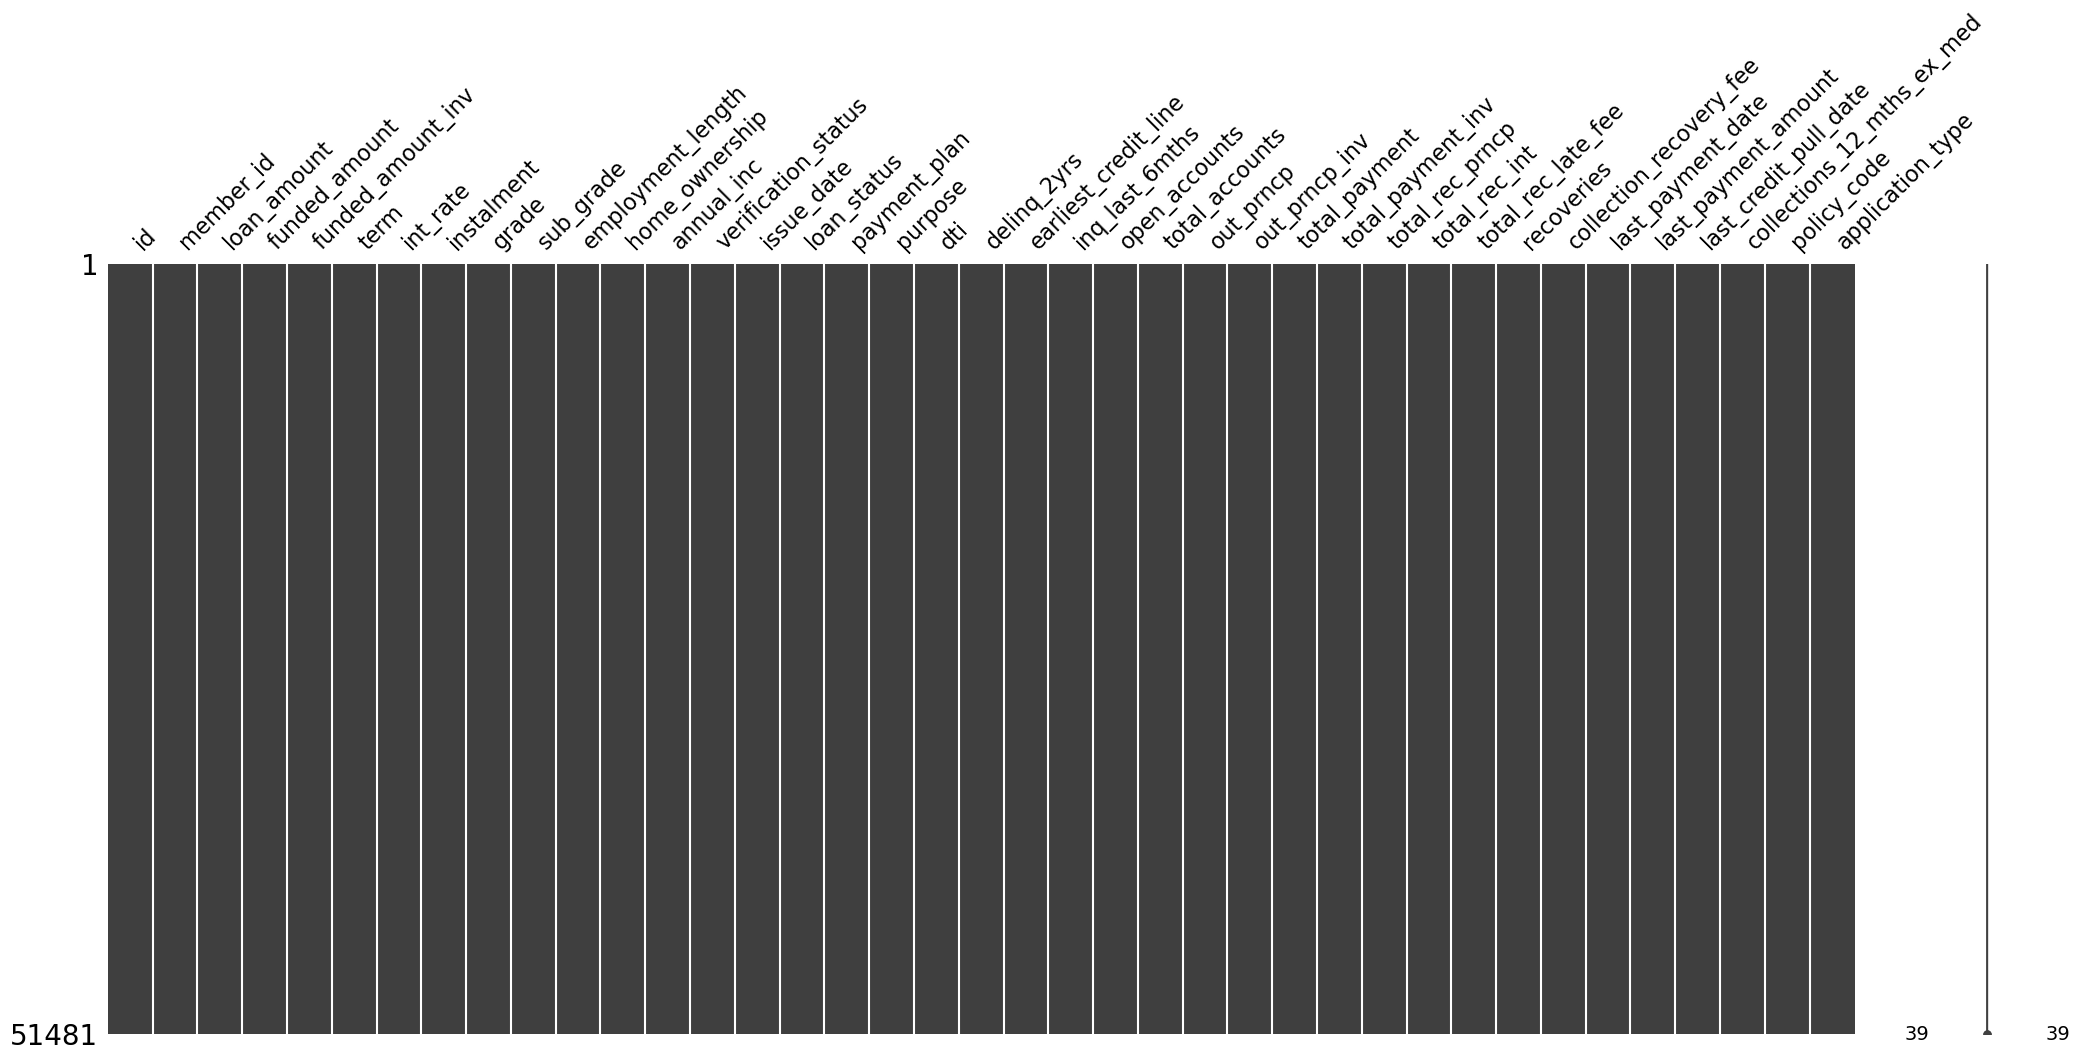

In [18]:
msno.matrix(df_transform.df)

We can see there are no null recrods left in the dataset.

## Save dataframe for future analysis.

In [19]:
df_transform.df.to_csv('loans_data_clean.csv', index=False)
print("Data saved to loans_data_clean.csv")

Data saved to loans_data_clean.csv


## Handling Skewewd Data
Skewed data can lead to biased models and inaccurate results, so it's important to address this issue before proceeding with any analysis.

To analyse the skew of the data we select for numeric data and also remove numeric columns that are not of interest, such as `member_id`.

In [20]:
numeric_cols = list(df_transform.df.select_dtypes(include=['float64', 'int64']).columns)
remove = ['id', 'member_id','policy_code'] # columns to not include in skew analysis

for i in remove:
    numeric_cols.remove(i)

print(numeric_cols)

['loan_amount', 'funded_amount', 'funded_amount_inv', 'int_rate', 'instalment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_accounts', 'total_accounts', 'out_prncp', 'out_prncp_inv', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_payment_amount', 'collections_12_mths_ex_med']


Calculate skewness and determine a threshold for the skewness of the data, over which a column will be considered skewed.

In [21]:
skewness = df_transform.df[numeric_cols].skew()
print(f"Skewness values:\n{skewness}")

Skewness values:
loan_amount                    0.803853
funded_amount                  0.819157
funded_amount_inv              0.811923
int_rate                       0.419765
instalment                     0.996692
annual_inc                     8.891838
dti                            0.196930
delinq_2yrs                    5.267731
inq_last_6mths                 3.269220
open_accounts                  1.037951
total_accounts                 0.775900
out_prncp                      2.358020
out_prncp_inv                  2.358480
total_payment                  1.247699
total_payment_inv              1.237368
total_rec_prncp                1.247760
total_rec_int                  2.166401
total_rec_late_fee            10.808115
recoveries                    13.277876
collection_recovery_fee       28.675651
last_payment_amount            2.471201
collections_12_mths_ex_med    20.798224
dtype: float64


A normal distribution has a skew of 0, we can see all of the columns have a positive skew and that our data is not normally distributed. When dealing with normally distributed data, a skewness threshold of ±0.5 is often used. For less strict symmetry, a threshold of ±1 is reasonable.

In [22]:
threshold = 1  
highly_skewed_cols = skewness[abs(skewness) > threshold]

print("\nHighly skewed columns:\n", highly_skewed_cols)
skewed_col_names = highly_skewed_cols.index.tolist()
skewed_col_names = ['loan_amount','dti']


Highly skewed columns:
 annual_inc                     8.891838
delinq_2yrs                    5.267731
inq_last_6mths                 3.269220
open_accounts                  1.037951
out_prncp                      2.358020
out_prncp_inv                  2.358480
total_payment                  1.247699
total_payment_inv              1.237368
total_rec_prncp                1.247760
total_rec_int                  2.166401
total_rec_late_fee            10.808115
recoveries                    13.277876
collection_recovery_fee       28.675651
last_payment_amount            2.471201
collections_12_mths_ex_med    20.798224
dtype: float64


### Perform Transformations 

We will perform severeal transformations on these columns to determine which transformation results in the biggest reduction in skew. 

In [23]:
skew_transformed_df, best_transformations_dict = df_transform.skew_transform(skewed_col_names)

             Original       Log  Square Root  Reciprocal
loan_amount  0.803853 -0.679245     0.163184    3.962246
dti          0.196930 -1.371575    -0.569006   22.181982


### Visualising Skew

The figure below displays each column above the skew threshold, and plots the original data alongside each transformation applied. The red plots indicate the best transformation to apply for each column.

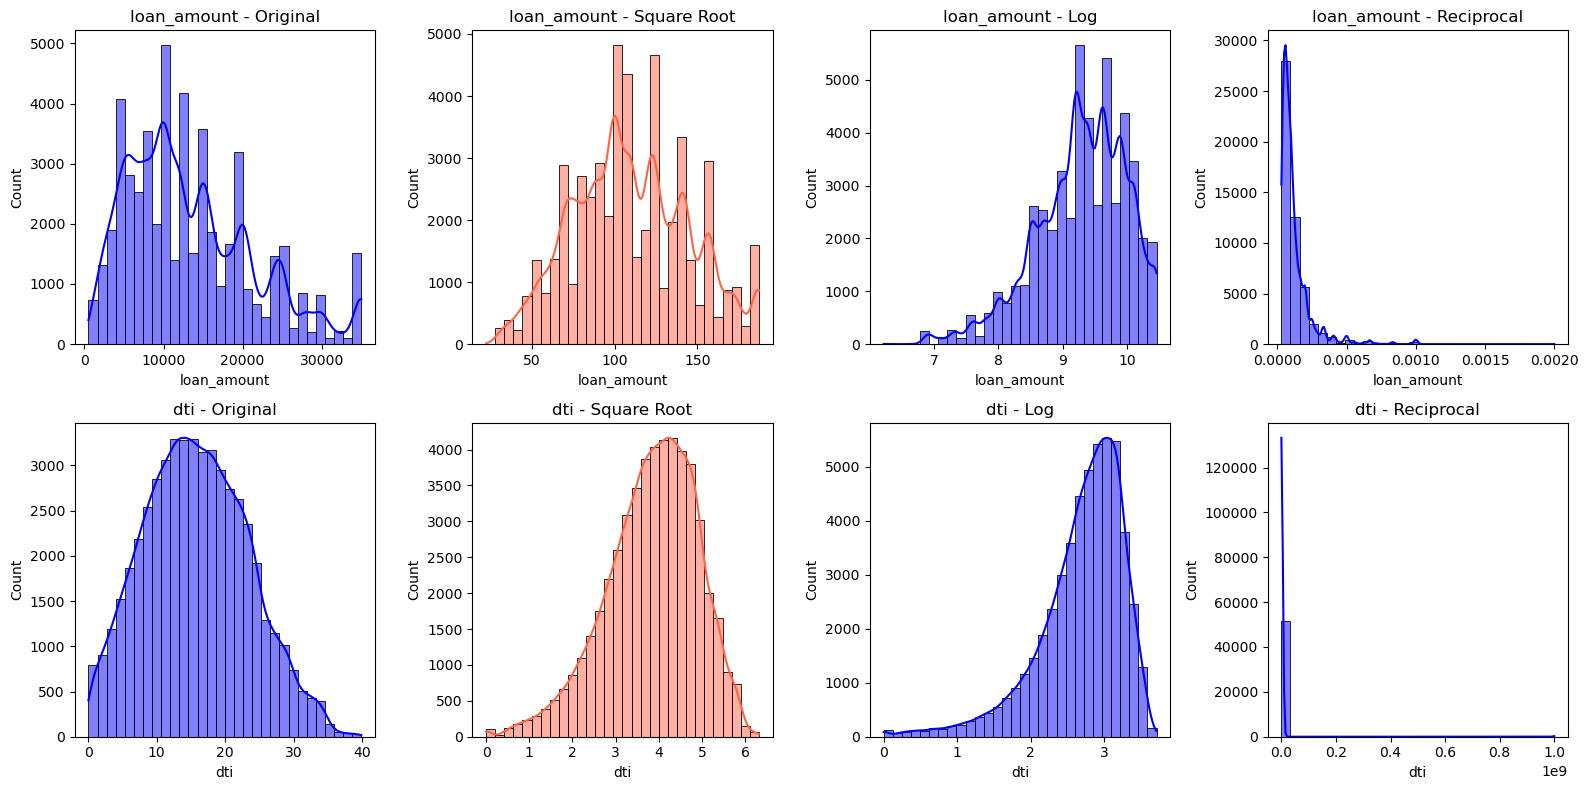

In [24]:
df_transform.plot_skew_transformations(skewed_col_names,best_transformations_dict)

## Removing Outliers

Outliers are samples which lie outside the range of expected values, removing outliers is an essential step in preparing data for machine learning. Outliers can be spotted by visual inspection and calculated by using methods such as the Interquartile Range Method or Z-Score Method. The Z-Score Method is not appropriate in this case as the data is not normally distributed. An adapted IQR method will be used for variables that have many zero values such as the delinq_2years which measures how many delinquencies a customer has had in the past 2 years. Most customers have no delinquencies so calculating outliers for these variables must be adapted to account for the expected zero values.

#### Visualising Outliers

c:\Users\noemi\Miniconda3\envs\datascience_env\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


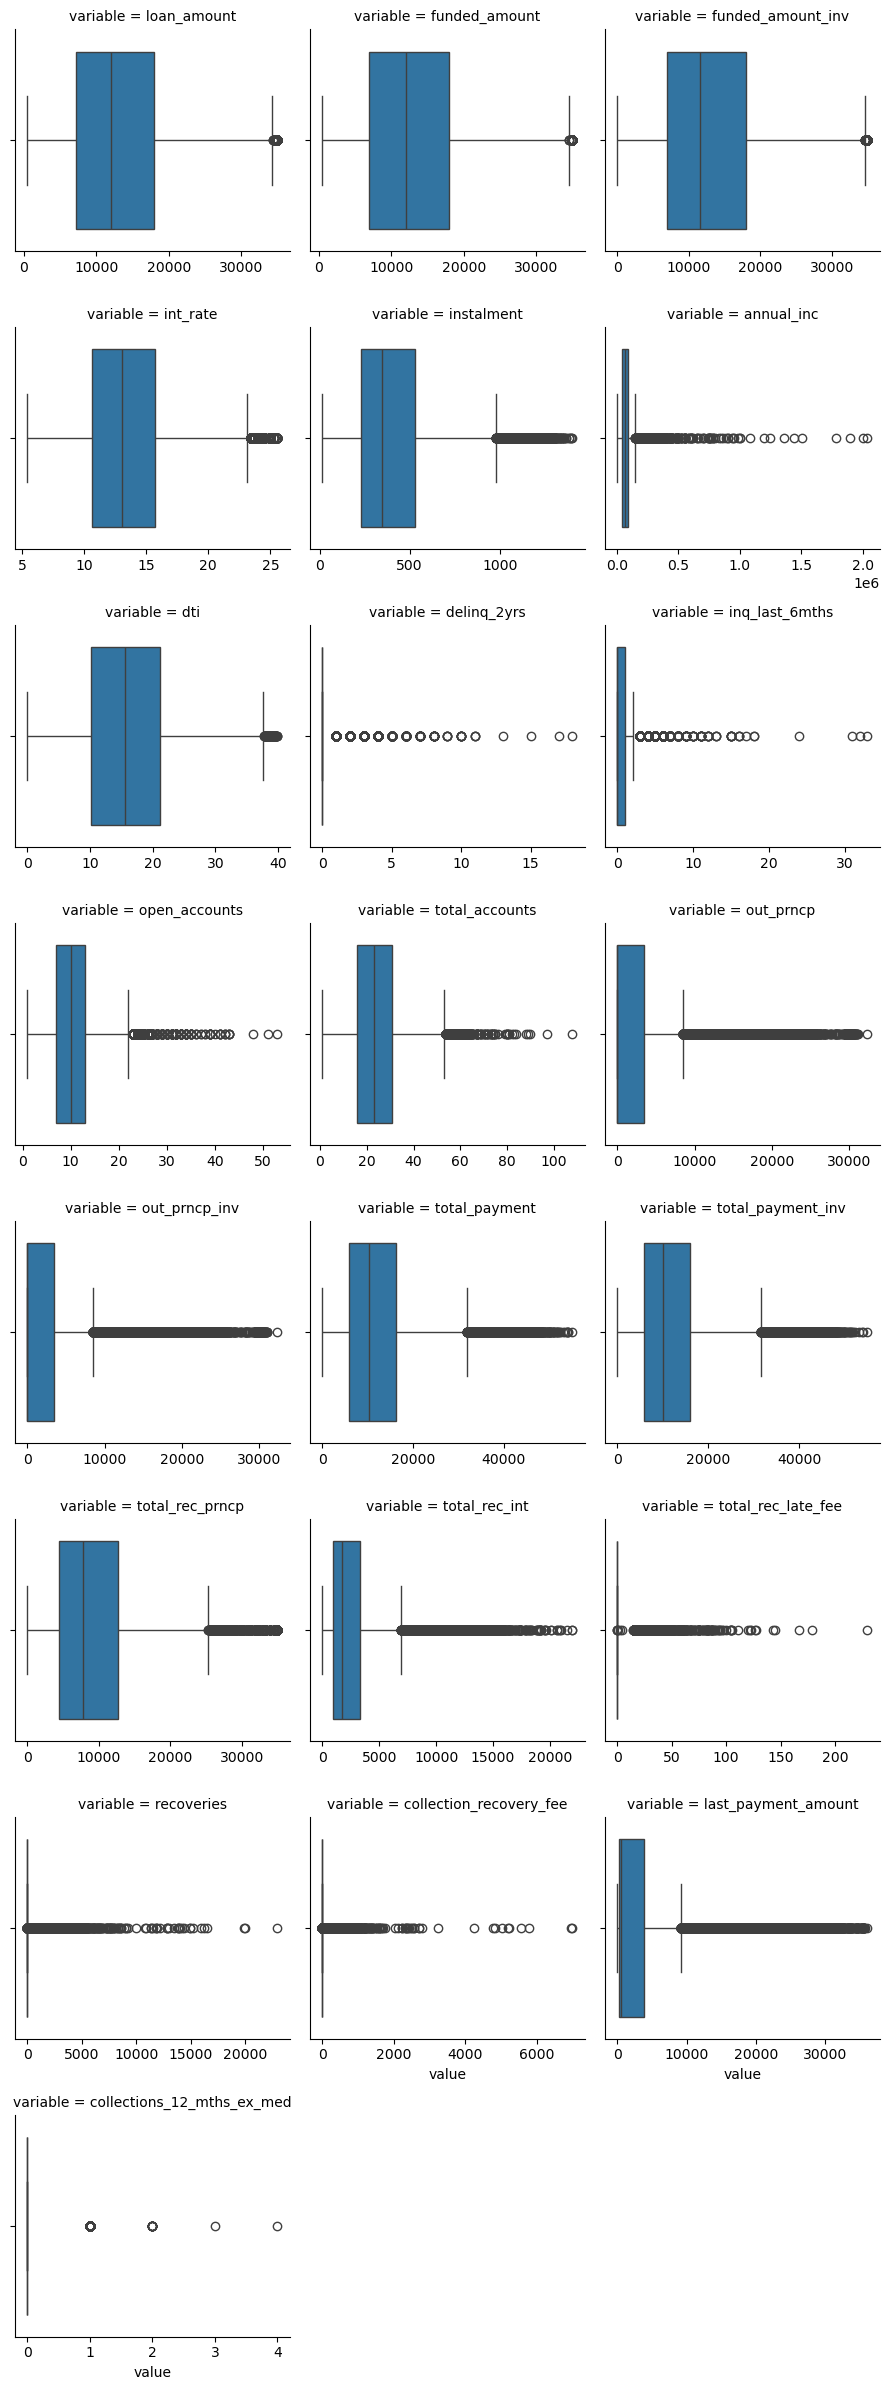

In [25]:
data_vis.facetgrid(numeric_cols, "box")

The plots show the outliers as the circles outside of the whiskers of the boxplot. We can see for variables that have many zero values that there are many outliers.

#### Removing Outliers

The variables have been split into two groups. The first group will have outliers removed using the traditional IQR Method where the threshold is +/- 1.5 *IQR. The second group is for variables that have meaningful zero values, and the thresholds are relaxed  to +/- 3 * IQR. 

In [26]:
#sort columns into different methods to remove outliers
IQR_cols = ['loan_amount', 'funded_amount', 'funded_amount_inv',
       'int_rate', 'instalment', 'annual_inc', 'dti', 'open_accounts', 'total_accounts',
       'total_payment', 'total_payment_inv',
       'total_rec_prncp', 'total_rec_int', 
       'last_payment_amount',
       ]

for col in IQR_cols:
    df_no_outliers = df_transform.remove_outliers_iqr(col)
    
#'out_prncp', 'out_prncp_inv' , zero means nothing outstanding

IQR_mod = [ 'delinq_2yrs', 'inq_last_6mths',
           'out_prncp', 'out_prncp_inv',
           'total_rec_late_fee', 'recoveries',
           'collection_recovery_fee',
           'collections_12_mths_ex_med'
           ]

for col in IQR_mod:
    df_no_outliers = df_transform.remove_outliers_modified_iqr(col)

## Dropping Overly Correlated Columns

Highly correlated columns in a dataset can lead to multicollinearity issues, which can affect the accuracy and interpretability of models built on the data.

#### Visualise the correlation matrix

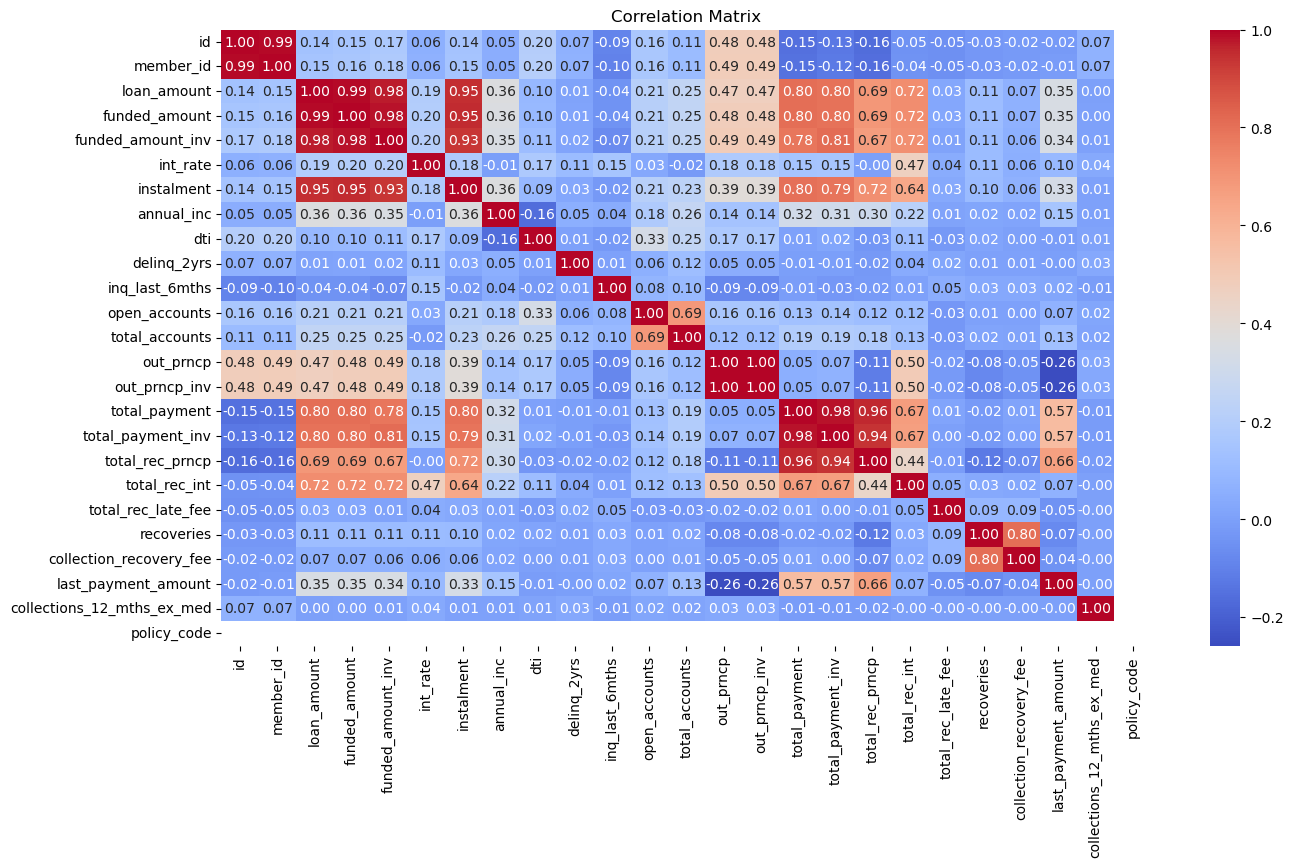

In [27]:
numeric_df = df_no_outliers.select_dtypes(include=['number'])

corr_matrix = numeric_df.corr()

data_vis.heatmap(corr_matrix,'Correlation Matrix')


We can see two clusters of very high correlation (>0.9). The first in the top right between loan_amount, funded_amount, funded_amount_inv, and instalment. This makes sense as the latter three are based on the first. The second cluster in the bottom left is between total_payment, total_payment_inv, total_rec_prncp which is expected. Another obvious insight from the heatmap is that out_prncp and put_prncp_inv are perfectly correlated.

### Identify Highly Correlated Columns

Based on the heatmap I will choose a threshold of 0.9

In [28]:
# Set a correlation threshold
threshold = 0.9

high_corr_pairs = np.where(np.abs(corr_matrix) > threshold)

# Filter out pairs where the correlation is not with itself
high_corr_pairs = [(corr_matrix.columns[x], corr_matrix.columns[y]) 
                   for x, y in zip(*high_corr_pairs) 
                   if x != y and x < y]

print("Highly correlated pairs:")
for pair in high_corr_pairs:
    print(pair)

Highly correlated pairs:
('id', 'member_id')
('loan_amount', 'funded_amount')
('loan_amount', 'funded_amount_inv')
('loan_amount', 'instalment')
('funded_amount', 'funded_amount_inv')
('funded_amount', 'instalment')
('funded_amount_inv', 'instalment')
('out_prncp', 'out_prncp_inv')
('total_payment', 'total_payment_inv')
('total_payment', 'total_rec_prncp')
('total_payment_inv', 'total_rec_prncp')


#### Step 3: Decide Which Columns to Remove

In [29]:
columns_to_remove = set()

# Iterate through the highly correlated pairs and remove the second columns
for col1, col2 in high_corr_pairs:
    columns_to_remove.add(col2)

print("Columns to remove:", columns_to_remove)

Columns to remove: {'total_rec_prncp', 'funded_amount_inv', 'funded_amount', 'member_id', 'out_prncp_inv', 'instalment', 'total_payment_inv'}


A threshold of 0.9 removes 7 columns:
funded_amount, funded_amount_inv, instalment, total_payment_inv, total_rec_prncp, out_prncp_inv, member_id.

In [30]:
df_reduced = df_no_outliers.drop(columns=columns_to_remove)